
### Objectiu del departament d'Anàlisi de Perfil Client:

> Quines combinacions de característiques demogràfiques (com edat, nivell educatiu i ocupació) són més comunes entre els clients que utilitzen múltiples productes financers del banc: loan, hipoteca, dipòsit?

### Llibreries i càrrega de dades

In [3]:
"""Libreries que poden ser necessàries"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"
from plottable import Table         # Visualización de tablas
import matplotlib.colors as mcolors # Colores y mapas de colores

# Clustering y agrupamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes


In [4]:
# %pip install plottable
# %pip install kmodes


In [5]:
df = pd.read_csv("../Data/df_250519.csv")

Paleta de colors

In [6]:
custom_palette = ["#AABBC8", "#2CCED1", "#5F6F81", "#DCE3EA", "#2E2F36"]  
sns.set_palette(sns.color_palette(custom_palette))

### Extracte KPIs

In [7]:

# Variables 
contactados   = df.nunique().id                                     # Número total de clientes contactados
suscribieron  = df[df['deposit'] == True].nunique().id             # Número de clientes que suscribieron 
duracion_llam = df[df['deposit'] == True].duration.sum()           # Duración de llamadas a suscriptores
llam_telf = df[df['contact'] == 'telephone']['campaign'].sum()      # Número de llamadas realizadas por teléfono
llam_cell = df[df['contact'] == 'cellular']['campaign'].sum()       # Número de llamadas realizadas por movil
llam = df['campaign'].sum()                                         # Número total de llamadas
contatos_previos_sus = df[df['deposit'] == True]['previous'].sum() # Número de contactos previos a suscriptores
suscribieron_por_mes = df[df['deposit'] == True].groupby('month').count()['deposit']  # Suscriptores en el mes
contactos_por_mes = df.groupby('month').count()['deposit']          # clientes contactados en el mes      
conversion_por_mes = suscribieron_por_mes / contactos_por_mes       # conversión por mes


# Prints
print("El número total de clientes contactados es:",contactados)
print("El número de suscriptores es:",suscribieron)
print("La duración total de las llamadas a suscriptores es:",duracion_llam)
print("El número de llamadas realizadas a teléfono fijo es: ", llam_telf)
print("El número de llamadas realizadas a móvil es: ", llam_cell)
print("El número total de llamadas realizadas es: ", llam)
print("El número total de contactos previos de los suscriptores es:", contatos_previos_sus)
print("La conversión por mes es: ", conversion_por_mes)

El número total de clientes contactados es: 16163
El número de suscriptores es: 7712
La duración total de las llamadas a suscriptores es: 4161406
El número de llamadas realizadas a teléfono fijo es:  3274
El número de llamadas realizadas a móvil es:  28002
El número total de llamadas realizadas es:  40513
El número total de contactos previos de los suscriptores es: 9149
La conversión por mes es:  month
Apr    0.632210
Aug    0.456830
Dec    0.910256
Feb    0.579892
Jan    0.408537
Jul    0.413684
Jun    0.447770
Mar    0.903704
May    0.334953
Nov    0.420236
Oct    0.837500
Sep    0.842333
Name: deposit, dtype: float64


In [8]:
#KPIs
kpi1 = suscribieron/contactados          # porcentaje de conversión a depósito
kpi2 = duracion_llam/suscribieron        # promedio de duración de llamadas a suscriptores
kpi3_tel = llam_telf/llam                # porcentaje de llamadas a teléfono
kpi3_cell = llam_cell/llam               # porcentaje de llamadas a móvil
kpi3 = (llam_telf+llam_cell)/llam        # porcentaje de llamadas a teléfono o móvil
kpi4 = contatos_previos_sus/suscribieron # promedio de contactos previos a suscriptores
kpi5 = conversion_por_mes.idxmax()       # mes con mayor tasa de conversión
kpi5_tasa = conversion_por_mes.max()     # tasa de conversión del mes con mayor tasa de conversión




# Prints
print("KPI 1: El porcentaje de conversión a depósito es ",kpi1*100,"%")
print("KPI 2: La duración media de las llamadas a suscriptoreses",kpi2)
# print("KPI 3: El porcentaje de llamadas realizadas por teléfono o móvil es ",kpi3*100,"%")
print("KPI 3.1: El porcentaje de llamadas realizadas por teléfono fijo es ",kpi3_tel*100,"%")
print("KPI 3.2: El porcentaje de llamadas realizadas por teléfono móvil es ",kpi3_cell*100,"%")
print("KPI 4: El porcentaje de contactos previos a suscriptores es ",kpi4)
print("KPI 5: El mes amb millor conversió ha sigut", kpi5, "amb una taxa de conversió de", kpi5_tasa)

KPI 1: El porcentaje de conversión a depósito es  47.713914496071276 %
KPI 2: La duración media de las llamadas a suscriptoreses 539.6014004149378
KPI 3.1: El porcentaje de llamadas realizadas por teléfono fijo es  8.081356601584677 %
KPI 3.2: El porcentaje de llamadas realizadas por teléfono móvil es  69.11855453804951 %
KPI 4: El porcentaje de contactos previos a suscriptores es  1.1863329875518671
KPI 5: El mes amb millor conversió ha sigut Dec amb una taxa de conversió de 0.9102564102564102


# Anàlisi 

Volem saber, dels clients del banc, quins són els perfils més comuns (3 variables)?


In [9]:
# Tractament de les dades

# Suposem que el teu DataFrame es diu df
df = df[['age', 'job', 'marital', 'education']]

# Eliminem files amb valors nuls
df_clean = df.dropna()



In [10]:
# Codificació de columnes categòriques
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['job', 'marital', 'education']
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df_clean[categorical_cols])

# Convertim a DataFrame i combinem amb 'age'
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))
df_encoded = pd.concat([df_clean[['age']].reset_index(drop=True), encoded_df], axis=1)


In [11]:
# Normalització (opcional però recomanada)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

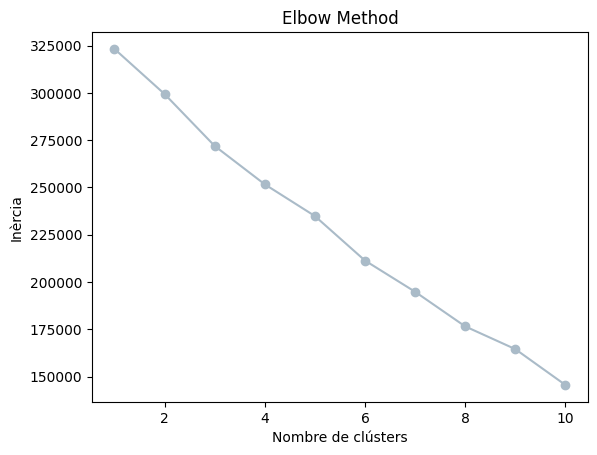

In [12]:
# Seleccionar el nombre òptim de clústers (opcional)

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Nombre de clústers')
plt.ylabel('Inèrcia')
plt.title('Elbow Method')
plt.show()


In [13]:
# Aplicar K-Means

kmeans = KMeans(n_clusters=6, random_state=42)  # Tria el nombre òptim de clústers
clusters = kmeans.fit_predict(df_scaled)

# Afegim els resultats al DataFrame original
df_clean['cluster'] = clusters


<Axes: xlabel='age', ylabel='education'>

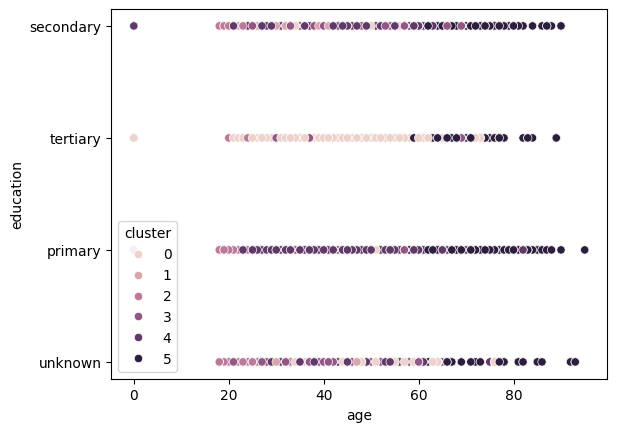

In [14]:
# Visualització dels clústers

import seaborn as sns

sns.scatterplot(data=df_clean, x='age', y='education', hue='cluster')  # o altres variables


In [15]:
# Obtenir els centroides
centroids = kmeans.cluster_centers_



In [16]:
# Valorr nomalitzats
# Tornar a l'espai original (desnormalitzar)
centroids_original = scaler.inverse_transform(centroids)

# Convertir-ho en DataFrame per llegir-ho més fàcilment
centroids_df = pd.DataFrame(centroids_original, columns=df_encoded.columns)

print(centroids_df)

         age    job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
0  39.637386  5.219605e-02     9.335879e-03      4.137492e-02   1.379164e-02   
1  37.933080 -3.747003e-16     2.498002e-16      7.632783e-17  -6.938894e-17   
2  26.116858 -1.526557e-16     1.110223e-16      2.428613e-17  -1.734723e-17   
3  39.305424 -4.440892e-16     3.608225e-16      1.457168e-16   1.422473e-16   
4  40.621344  2.931755e-01     4.897284e-01      4.892061e-02   5.832173e-02   
5  65.319964 -3.608225e-16     2.498002e-16      5.204170e-17  -1.040834e-17   

   job_management   job_retired  job_self-employed  job_services  \
0    7.873966e-01 -4.302114e-16       7.107999e-02  6.383782e-16   
1   -3.053113e-16 -5.551115e-17      -4.163336e-17  1.000000e+00   
2    1.665335e-16 -2.775558e-17      -6.938894e-18  0.000000e+00   
3    5.828671e-16 -3.330669e-16       1.873501e-16 -3.191891e-16   
4    2.220446e-15 -4.579670e-16       4.213092e-02  1.110223e-15   
5    3.053113e-16  1.000000e+00

In [17]:
# categories dominants

# Per identificar més fàcilment les columnes codificades
categorical_cols = ['job', 'marital', 'education']
encoded_colnames = encoder.get_feature_names_out(categorical_cols)

# Fem servir les mateixes columnes per reconstruir DataFrame
centroids_df = pd.DataFrame(centroids_original, columns=['age'] + list(encoded_colnames))

# Trobar la categoria dominant per clúster
cluster_summaries = []

for i, row in centroids_df.iterrows():
    summary = {"cluster": i, "age_mean": round(row['age'], 1)}
    
    for col_prefix in categorical_cols:
        # Filtrar les columnes relacionades amb aquesta variable (ex: job_admin., job_technician...)
        cols = [col for col in encoded_colnames if col.startswith(col_prefix + "_")]
        
        # Trobar la categoria amb el valor més alt al centreide
        best_col = max(cols, key=lambda x: row[x])
        
        # Afegir la categoria al resum
        summary[col_prefix] = best_col.replace(col_prefix + "_", "")
    
    cluster_summaries.append(summary)

# Convertim a DataFrame
summary_df = pd.DataFrame(cluster_summaries)

print(summary_df)



   cluster  age_mean          job  marital  education
0        0      39.6   management  married   tertiary
1        1      37.9     services  married  secondary
2        2      26.1      student   single  secondary
3        3      39.3   technician  married  secondary
4        4      40.6  blue-collar  married  secondary
5        5      65.3      retired  married  secondary


In [18]:
# Codi per calcular la proporció de cada clúster

# Comptar i calcular proporcions
cluster_counts = df_clean['cluster'].value_counts()
cluster_proportions = cluster_counts / len(df_clean)

# Crear DataFrame
proportions_df = pd.DataFrame({
    'cluster': cluster_counts.index,
    'count': cluster_counts.values,
    'proportion': cluster_proportions.values
})

# Afegir columna en percentatge
proportions_df['proportion (%)'] = (proportions_df['proportion'] * 100).round(2)

# Ordenar per proporció descendent
proportions_df = proportions_df.sort_values(by='proportion', ascending=False).reset_index(drop=True)

print(proportions_df)


   cluster  count  proportion  proportion (%)
0        4   5744    0.355380           35.54
1        0   4713    0.291592           29.16
2        3   2747    0.169956           17.00
3        1   1315    0.081359            8.14
4        5   1122    0.069418            6.94
5        2    522    0.032296            3.23


# Resultats

| Clúster | %     | Perfil principal                                          |
| ------- | ----- | --------------------------------------------------------- |
| 0       | 35.5% | Professionals casats amb estudis superiors (`management`) |
| 1       | 29.2% | Treballadors del sector serveis casats                    |
| 3       | 17.0% | Tècnics qualificats amb estudis mitjans                   |
| 2       | 3.2%  | Estudiants joves solters                                  |
| 4       | 6.9%  | Treballadors manuals (blue-collar)                        |
| 5       | 8.1%  | Jubilats                                                  |


🟦 Clúster 4 (etiquetat com cluster = 0):
35.5% del total (el grup més gran).

Mitjana d’edat: 39.6

Tipus de feina dominant: management

Estat civil dominant: married

Educació dominant: tertiary (universitària)

💡 Interpretació:
Aquest clúster representa professionals amb estudis universitaris, d’edat mitjana, majoritàriament casats, i amb feines de responsabilitat (gestió). Pot representar el perfil de classe mitjana-alta professional.

🟨 Clúster 0 (cluster = 1):
29.2% del total

Edat mitjana: 37.9

Feina: services

Estat civil: married

Educació: secondary

💡 Interpretació:
Adults joves/adults, amb treballs en el sector serveis i formació secundària. Podria ser classe treballadora establerta.

🟩 Clúster 3 (cluster = 2):
3.2% del total (el més petit)

Edat mitjana: 26.1

Feina: student

Estat civil: single

Educació: secondary

💡 Interpretació:
Clúster petit format per estudiants joves solters. Té sentit que sigui petit, ja que el perfil d’estudiant és molt específic i no generalitzat dins del conjunt.

🟧 Clúster 1 (cluster = 3):
17.0% del total

Edat mitjana: 39.3

Feina: technician

Estat civil: married

Educació: secondary

💡 Interpretació:
Treballadors tècnics amb educació secundària i edat mitjana. Possiblement classe treballadora especialitzada o tècnica.

🟥 Clúster 5 (cluster = 4):
6.9% del total

Edat mitjana: 40.6

Feina: blue-collar

Estat civil: married

Educació: secondary

💡 Interpretació:
Treballadors manuals (colze blau), amb educació secundària. Similar al clúster anterior, però probablement amb menys qualificació tècnica. Representa treballadors industrials o operaris.

🟪 Clúster 2 (cluster = 5):
8.1% del total

Edat mitjana: 65.3

Feina: retired

Estat civil: married

Educació: secondary

💡 Interpretació:
Jubilats, de mitjana edat avançada. Grup específic i clarament diferenciat per edat i ocupació.

# Visualització dels perfils

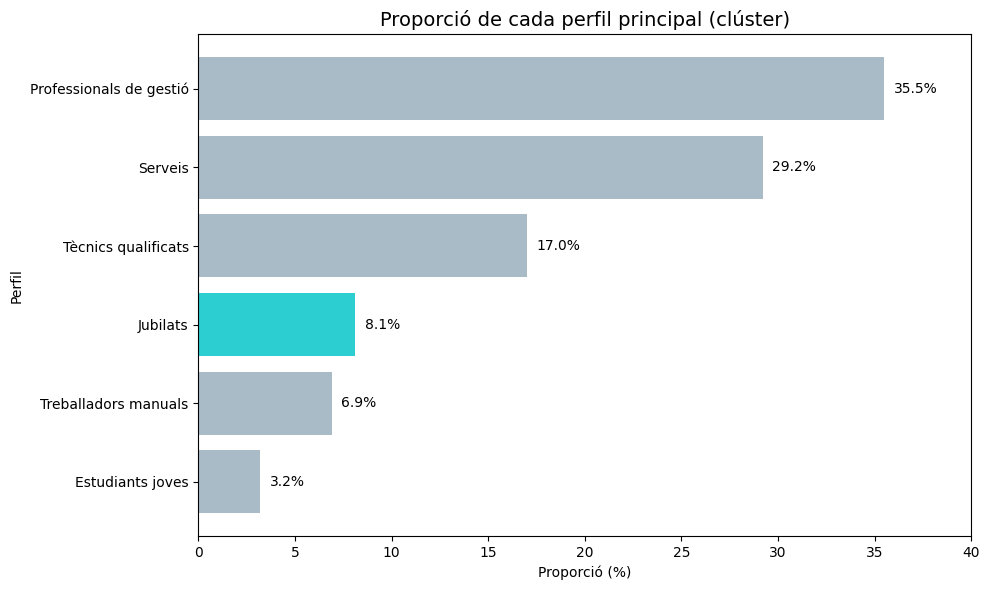

In [29]:


# Perfils i percentatges
perfils = [
    "Professionals de gestió",
    "Serveis",
    "Tècnics qualificats",
    "Jubilats",
    "Treballadors manuals",
    "Estudiants joves"
]

proporcions = [35.5, 29.2, 17.0, 8.1, 6.9, 3.2]

# Paleta: destacant Jubilats
colors = []
for perfil in perfils:
    if perfil == "Jubilats":
        colors.append("#2CCED1")  # turquesa destacat
    else:
        colors.append("#AABBC8")  # color base

# Gràfic
plt.figure(figsize=(10,6))
bars = plt.barh(perfils, proporcions, color=colors)

# Etiquetes a cada barra
for i, (valor, perfil) in enumerate(zip(proporcions, perfils)):
    plt.text(valor + 0.5, i, f"{valor:.1f}%", va='center', fontsize=10)

# Format
plt.title("Proporció de cada perfil principal (clúster)", fontsize=14)
plt.xlabel("Proporció (%)")
plt.ylabel("Perfil")
plt.xlim(0, 40)
plt.gca().invert_yaxis()  # Mostrar els més grans a dalt
plt.tight_layout()
plt.show()



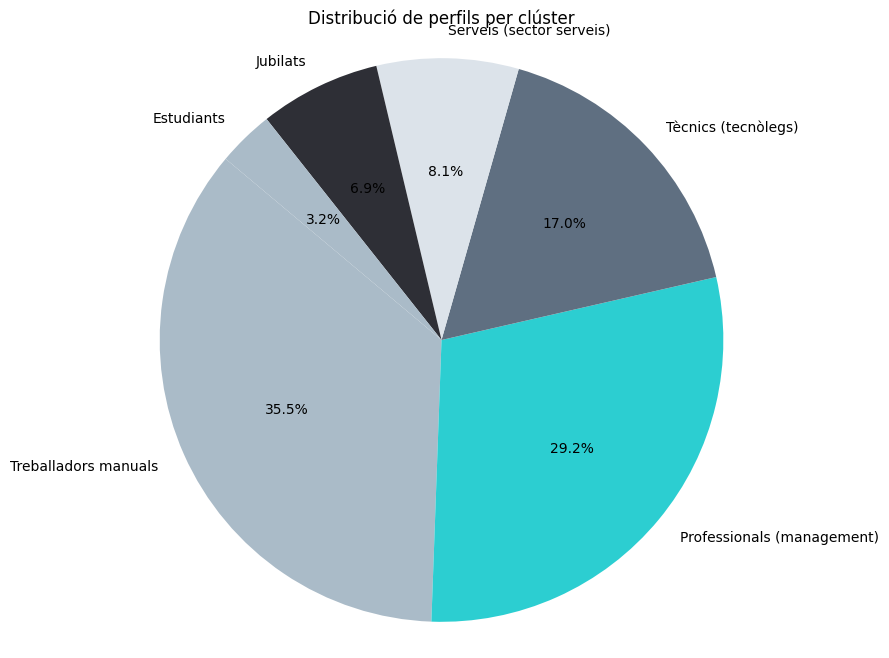

In [27]:
plt.figure(figsize=(8,8))
plt.pie(
    proportions_df['proportion'],
    labels=proportions_df['perfil'],
    autopct='%1.1f%%',
    startangle=140,
    colors=custom_palette[:len(proportions_df)]  # assegurar que coincideix el número de clústers
)
plt.title('Distribució de perfils per clúster')
plt.axis('equal')
plt.show()



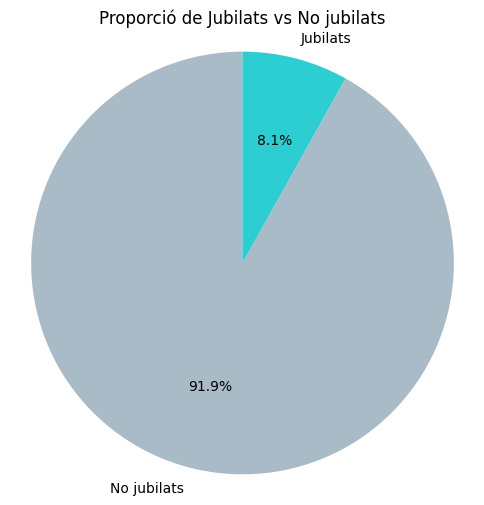

In [ ]:

labels = ['No jubilats', 'Jubilats']
sizes = [91.9, 8.1]  # jubilats primer
colors = [ '#AABBC8', '#2CCED1']

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,  # comença a les 12 en punt
    colors=colors
)
plt.title('Proporció de Jubilats vs No jubilats')
plt.axis('equal')
plt.show()
